In [1]:
!pip install -U tensorflow==2.17 #2.15 17 - wehere wixed tf lite coverter

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 601.3/601.3 MB 2.5 MB/s eta 0:00:000:00:0100:01
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.17.1
    Uninstalling tensorflow-2.17.1:
      Successfully uninstalled tensorflow-2.17.1


In [3]:
import numpy as np
import pandas as pd
from glob import glob
import os
import pathlib
import tensorflow as tf
import keras
import seaborn as sns

#models 
from tensorflow.keras.applications import EfficientNetB1, EfficientNetB3, EfficientNetB5

#preproces
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau

from PIL import Image
import cv2 as cv
import matplotlib.pyplot as plt


from sklearn.metrics import confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay, accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns


from collections import Counter
# for proper loading img
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [4]:
tf.__version__,#keras.__version__

('2.17.0',)

In [6]:
SIZE = 320 #300
BS = 32 #16

## Data Load

In [7]:
imgs = glob(r'/kaggle/input/food41/images/*/*')
labels = [el.split('/')[5] for el in imgs ]


## Visualisation

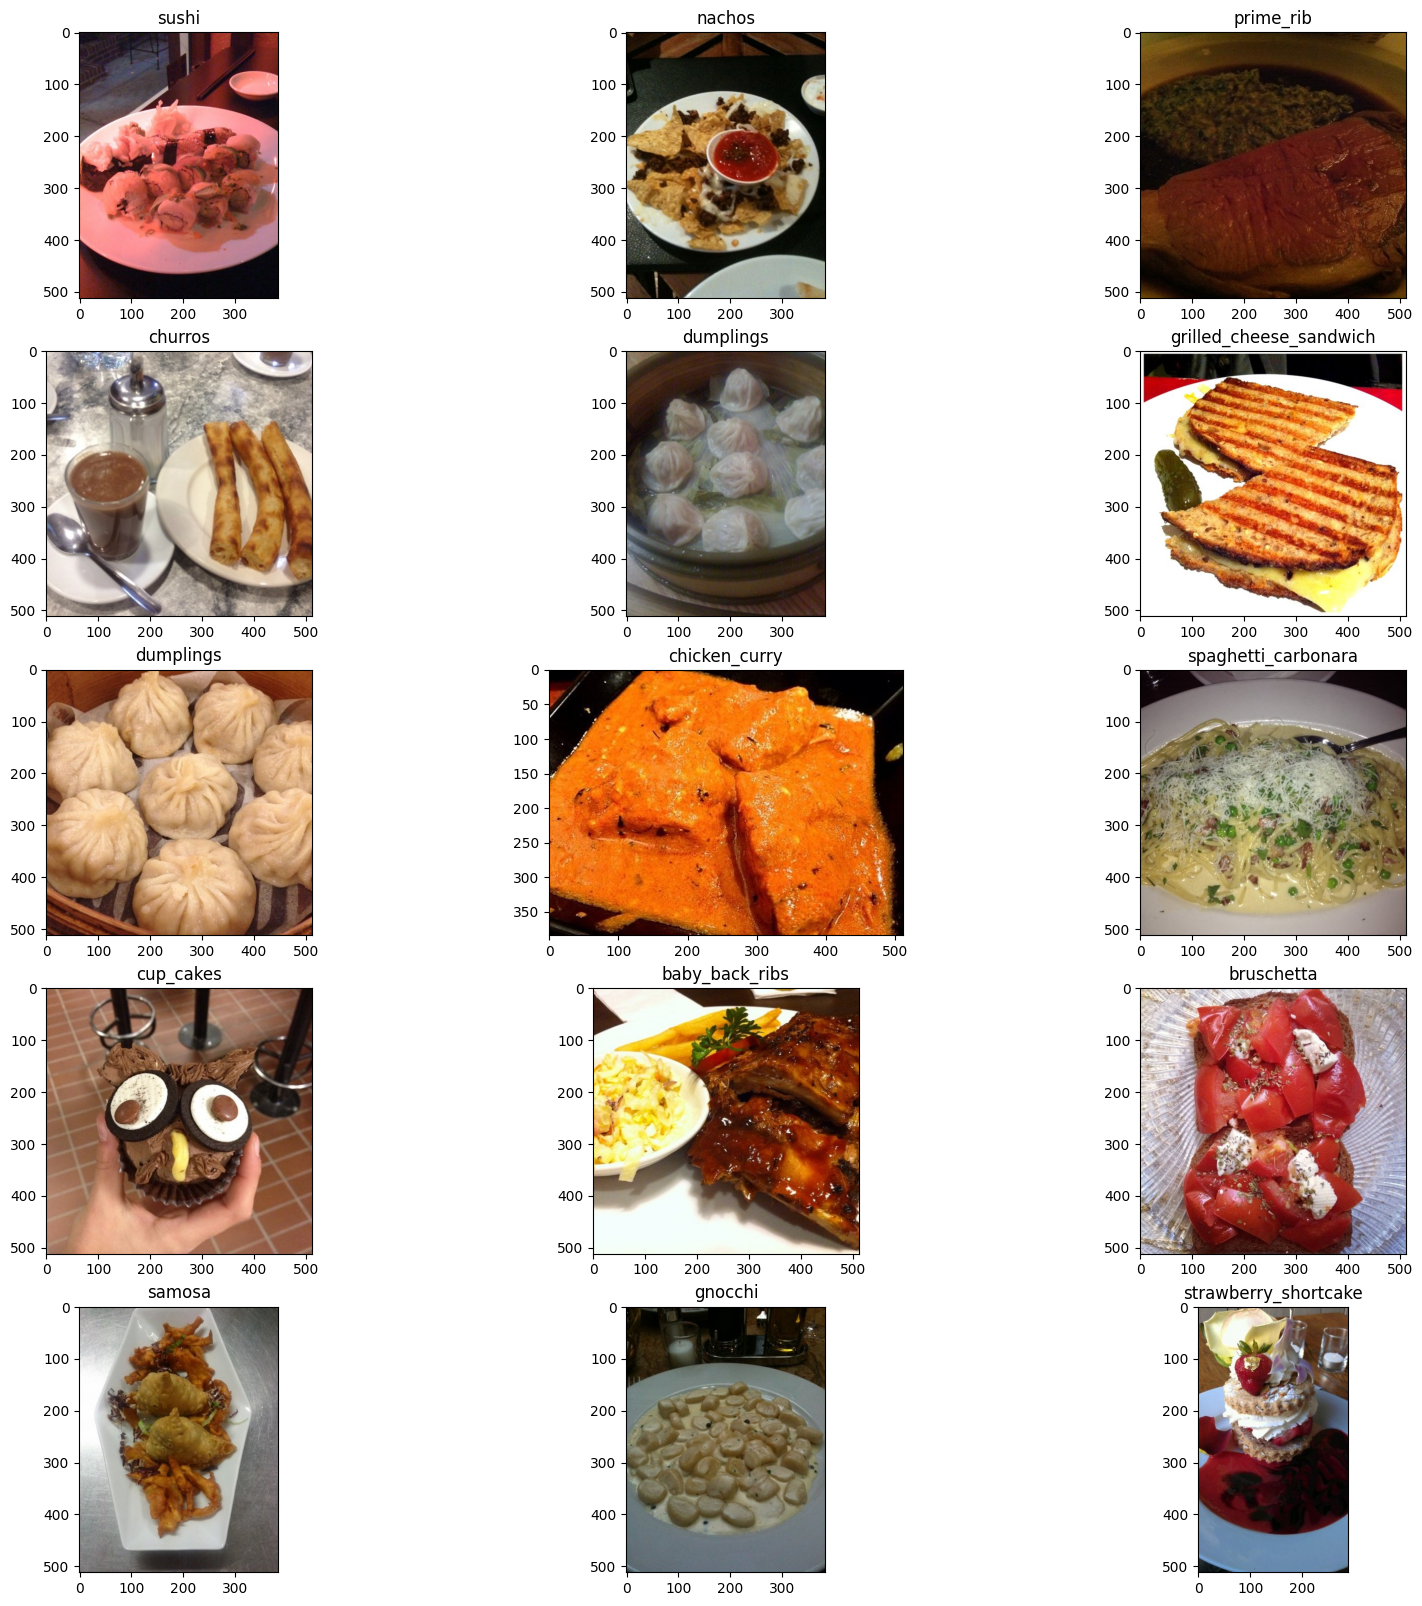

In [8]:
def visualisation(imgs, choise):
    
    fig, ax = plt.subplots(5, 3, figsize=(20, 20))
    fig.subplots_adjust()
    im_list = np.random.choice(imgs, choise)
    for axi, im in zip( ax.flat, im_list):
        axi.set_title(im.split('/')[5],)
        axi.imshow(plt.imread(im), )


visualisation(imgs, 15)

## Class distribution

In [9]:
counter_dict = {k:v for k,v in Counter(labels).items()} 
df = pd.DataFrame(counter_dict.items(),columns =['name', 'count'] )
df.describe()



,count
count,101.0
mean,1000.0
std,0.0
min,1000.0
25%,1000.0
50%,1000.0
75%,1000.0
max,1000.0


## median quantity imgs in class

In [10]:
len(imgs)/101

1000.0

## Make DF

In [11]:

df = pd.DataFrame(list(zip(imgs, labels)), columns =['X','y'])


In [12]:

df['y'].value_counts()

y
french_fries         1000
macarons             1000
french_toast         1000
lobster_bisque       1000
prime_rib            1000
                     ... 
beef_carpaccio       1000
poutine              1000
hot_and_sour_soup    1000
seaweed_salad        1000
foie_gras            1000
Name: count, Length: 101, dtype: int64

In [13]:
df['y'].value_counts().unique()

array([1000])

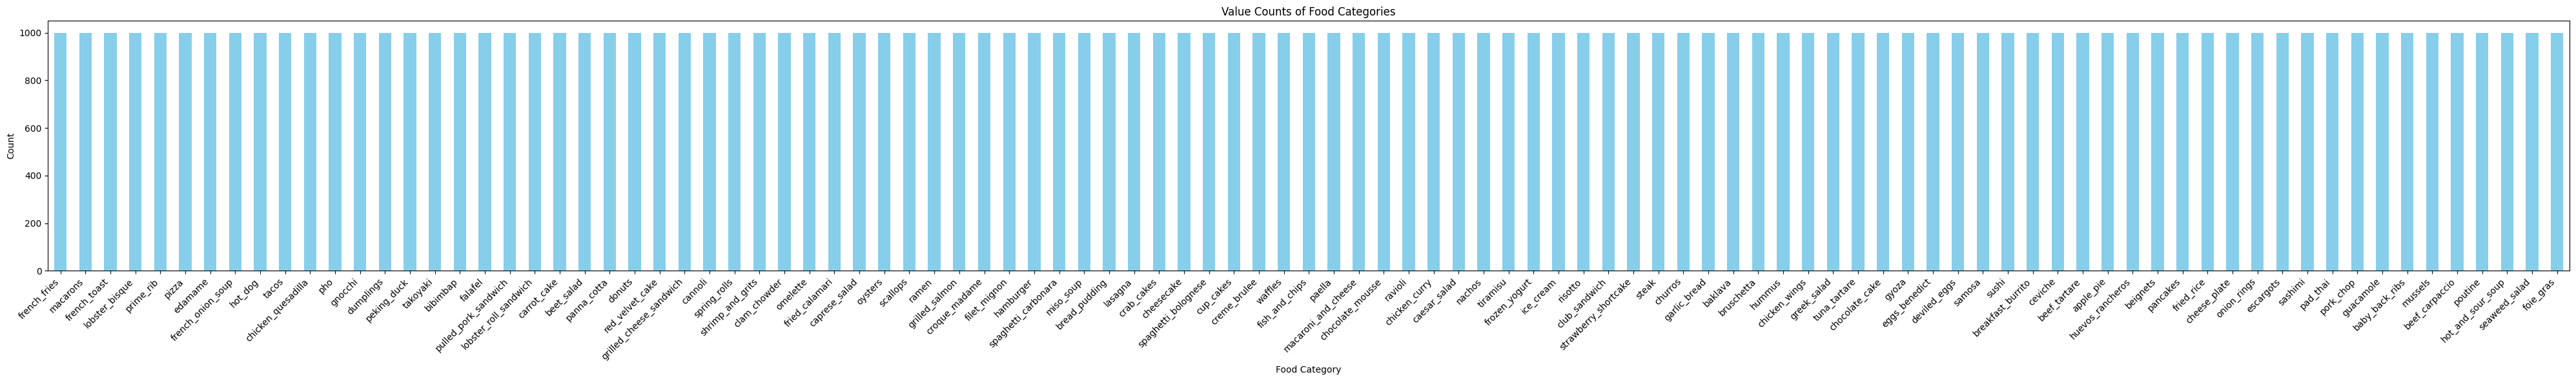

In [14]:


plt.figure(figsize=(40, 6))

df['y'].value_counts().plot(kind='bar', color='skyblue')
plt.xlabel('Food Category')
plt.ylabel('Count')
plt.title('Value Counts of Food Categories')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [15]:
X_train, X_test, y_train, y_test = train_test_split(imgs, labels, test_size=0.5, random_state=11, stratify=labels)
train = pd.DataFrame(list(zip(X_train,y_train)), columns =['X','y'])
test = pd.DataFrame(list(zip(X_test,y_test)), columns =['X','y'])

datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=30,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.15,
        zoom_range=0.15,)
valid_gen = ImageDataGenerator(rescale=1./255)



train_gen = datagen.flow_from_dataframe(train, x_col='X', y_col="y", target_size=(SIZE, SIZE), shuffle=True)
test_gen = valid_gen.flow_from_dataframe(test, x_col='X', y_col="y", target_size=(SIZE, SIZE), shuffle=False)

Found 50500 validated image filenames belonging to 101 classes.
Found 50500 validated image filenames belonging to 101 classes.


## Model

In [16]:
def build_model( num_classes=101, shape=(SIZE,SIZE,3)):
    
    inputs = tf.keras.layers.Input(shape=shape)
    model = EfficientNetB5(include_top=False, #EfficientNetB5
        weights='imagenet',
        input_tensor=inputs, # !
        input_shape=None,
        pooling=None,
        classifier_activation='softmax')
    
    model.trainable = True

    # Rebuild top
    x = tf.keras.layers.GlobalAveragePooling2D(name="avg_pool")(model.output) 
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout( 0.3, name="top_dropout")(x)
    x = tf.keras.layers.Dense(num_classes*4, activation="relu", kernel_initializer="he_normal",
                           kernel_regularizer=keras.regularizers.l1(0.033))(x)
   
    x = tf.keras.layers.Dropout( 0.3, name="top_dropout_2")(x)
    outputs = tf.keras.layers.Dense(num_classes, activation="softmax", name="pred")(x)
#kernel_initializer="he_normal",
                           #kernel_regularizer=keras.regularizers.l1(0.033)
    # Compile
    model = keras.Model(inputs, outputs, name="EfficientNetB1")

    loss = tf.keras.losses.CategoricalFocalCrossentropy(
        gamma=6,
        from_logits=False)
    
    learning_rate = 0.001
    

   
    optimizer = keras.optimizers.RMSprop(learning_rate=learning_rate)
    
    
    model.compile(loss=loss, metrics=['accuracy'], optimizer=optimizer)
    
    
    return model

model = build_model()

115263384/115263384 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [17]:
early_stop = EarlyStopping(monitor='val_loss', verbose=1, patience=3, restore_best_weights=True, start_from_epoch=5)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.6, patience=2, min_lr=1.0000e-08) #0

epoch = 10
history = model.fit(train_gen, validation_data=test_gen, epochs=epoch, callbacks=[early_stop, reduce_lr],  batch_size = BS )

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1579/1579 ━━━━━━━━━━━━━━━━━━━━ 2525s 1s/step - accuracy: 0.0313 - loss: 45.7313 - val_accuracy: 0.0449 - val_loss: 14.6827 - learning_rate: 0.0010
Epoch 2/10
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 2141s 1s/step - accuracy: 0.0415 - loss: 14.7761 - val_accuracy: 0.0595 - val_loss: 14.8225 - learning_rate: 0.0010
Epoch 3/10
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 2141s 1s/step - accuracy: 0.0631 - loss: 14.7907 - val_accuracy: 0.0963 - val_loss: 14.6987 - learning_rate: 0.0010
Epoch 4/10
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 2142s 1s/step - accuracy: 0.0809 - loss: 9.2870 - val_accuracy: 0.0749 - val_loss: 9.4906 - learning_rate: 6.0000e-04
Epoch 5/10
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 2141s 1s/step - accuracy: 0.0858 - loss: 9.2752 - val_accuracy: 0.1407 - val_loss: 9.1346 - learning_rate: 6.0000e-04
Epoch 6/10
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 2146s 1s/step - accuracy: 0.1009 - loss: 9.2616 - val_accuracy: 0.1491 - val_loss: 9.0308 - learning_rate: 6.0000e-04
Epoch 7/10
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 2144s 1s/step -

In [18]:
model.save('food101_efb3_030325_p10.h5')